Suppose we collect complete Fourier observations $y \in \mathbb{R}^M$ of some image $x \in \mathbb{R}^N$ under a forward model $\Phi = \mathsf{G}\mathsf{F}$, where $M \ll N$ and $\mathsf{G}$ / $\mathsf{F}$ are Fourier sub-sampling and transform respectively. Suppose further that our observational instrument introduces some uncertainty which can be adequately modelled by a univariate Gaussian $n = \mathcal{N}(0, \sigma) \in \mathbb{R}^N$. In this case our measurement equation is given by 

$$y = \Phi x + n.$$





In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc as misc 
from scipy.signal import resample

import optimusprimal as optpr
import ProxNest as prn
import ProxNest.operators as operators

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from matplotlib import pyplot as plt
plt.style.use('dark_background')
plt.rcParams["font.family"] = "serif"

# import optimusprimal.primal_dual as primal_dual
# import optimusprimal.grad_operators as grad_operators
# import optimusprimal.linear_operators as linear_operators
# import optimusprimal.prox_operators as prox_operators

In [2]:
# Auxiliary functions

def eval_snr(x, x_est):
    if np.array_equal(x, x_est):
        return 0
    num = np.sqrt(np.sum(np.abs(x) ** 2))
    den = np.sqrt(np.sum(np.abs(x - x_est) ** 2))
    return round(20*np.log10(num/den), 2)



First, we need to define some heuristics for the solver, these include:

      - tol: convergence criteria for the iterations
      - iter: maximum number of iterations
      - update_iter: iterations between logging iteration diagnostics
      - record_iters: whether to record the full diagnostic information



In [3]:
options = {"tol": 1e-5, "iter": 2500, "update_iter": 50, "record_iters": False}

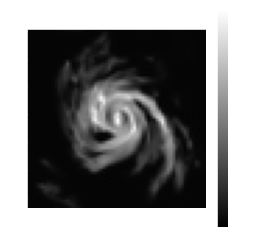

In [4]:
# Load Image
dim = 64
repo_dir = '/Users/tliaudat/Documents/postdoc/github/proxnest'
ground_truth = np.load(repo_dir + '/data/galaxy_image_{}.npy'.format(dim))

# Normalise magnitude
ground_truth -= np.nanmin(ground_truth)
ground_truth /= np.nanmax(ground_truth)
ground_truth[ground_truth<0] = 0

x = ground_truth

plt.figure(figsize=(4,4))
plt.imshow(ground_truth, cmap='gray');plt.colorbar()
plt.show()

In [5]:
# A mock radio imaging forward model with half of the Fourier coefficients masked
phi = operators.sensing_operators.MaskedFourier(dim, 0.5)


In [6]:
# Simulate mock noisy observations y
y = phi.dir_op(ground_truth)
ISNR = 25
sigma = np.sqrt(np.mean(np.abs(y)**2)) * 10**(-ISNR/20)
n = np.random.normal(0, sigma, y.shape)

# Simulate mock noisy observations
y += n


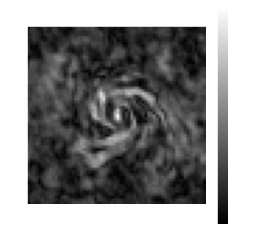

In [7]:
plt.figure(figsize=(4,4))
plt.imshow(abs(phi.adj_op(y)), cmap='gray');plt.colorbar()
plt.show()

## Primal-dual FB Wavelet-based denoiser

In [8]:
reg_param = 2.5e-3      

# Define the grad
g = optpr.grad_operators.l2_norm(sigma, y, phi)
g.beta = 1.0 / sigma ** 2

# Define the wavelet dict
wav = ["db1", "db4"]                                     # Wavelet dictionaries to combine
levels = 3                                               # Wavelet levels to consider [1-6]
psi = optpr.linear_operators.dictionary(wav, levels, x.shape)  # Wavelet linear operator

# Define the l1 norm prox with the dict psi
h = optpr.prox_operators.l1_norm(np.max(np.abs(psi.dir_op(abs(phi.adj_op(y))))) * reg_param, psi)
h.beta = 1.0

# Real prox 
r = optpr.prox_operators.real_prox()
# f = None


In [9]:
# Run the alg
x_init = np.abs(phi.adj_op(y))

wvlt_best_estimate, wvlt_diagnostics = optpr.primal_dual.FBPD(
    x_init=x_init, options=options, g=g, f=None, h=h, r=r
)


2023-02-01 13:22:12,770 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2023-02-01 13:22:12,777 - Optimus Primal - INFO - [Primal Dual] 0 out of 2500 iterations, tol = 0.612412
2023-02-01 13:22:12,930 - Optimus Primal - INFO - [Primal Dual] 50 out of 2500 iterations, tol = 0.000827
2023-02-01 13:22:13,069 - Optimus Primal - INFO - [Primal Dual] 100 out of 2500 iterations, tol = 0.000616
2023-02-01 13:22:13,199 - Optimus Primal - INFO - [Primal Dual] 150 out of 2500 iterations, tol = 0.000507
2023-02-01 13:22:13,331 - Optimus Primal - INFO - [Primal Dual] 200 out of 2500 iterations, tol = 0.000422
2023-02-01 13:22:13,460 - Optimus Primal - INFO - [Primal Dual] 250 out of 2500 iterations, tol = 0.000365
2023-02-01 13:22:13,591 - Optimus Primal - INFO - [Primal Dual] 300 out of 2500 iterations, tol = 0.000339
2023-02-01 13:22:13,719 - Optimus Primal - INFO - [Primal Dual] 350 out of 2500 iterations, tol = 0.000313
2023-02-01 13:22:13,847 - Optimus Primal - INFO - [Primal Du

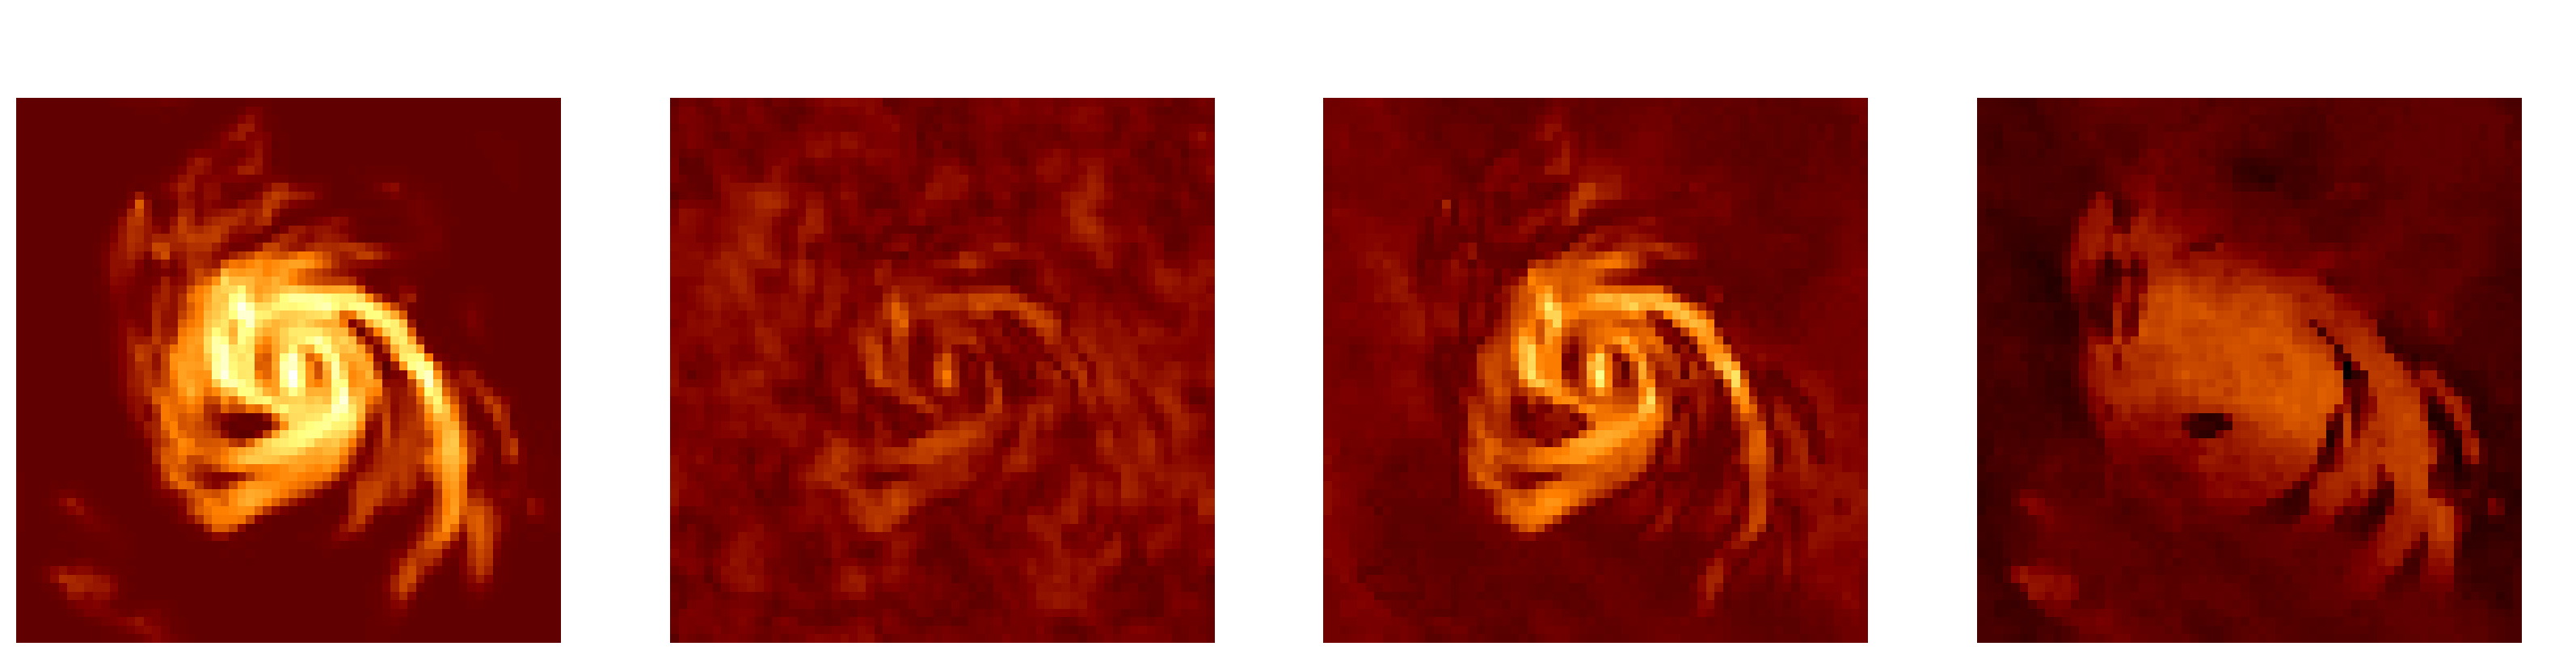

In [10]:

images = [x, x_init, np.abs(wvlt_best_estimate), x-np.abs(wvlt_best_estimate)]
labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]

fig, axs = plt.subplots(1,4, figsize=(20,8), dpi=200)
for i in range(4):
    axs[i].imshow(images[i], cmap='afmhot', vmax=np.nanmax(images), vmin=np.nanmin(images))
    if i > 0:   
        stats_str = '(PSNR: {},\n SNR: {}, SSIM: {})'.format(
            round(psnr(ground_truth, images[i]), 2),
            round(eval_snr(x, images[i]), 2),
            round(ssim(ground_truth, images[i]), 2),
            )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')

plt.show()



### Let's use the FB algorithm

In [77]:
reg_param_FB = 5e-2

# Define the grad
g = optpr.grad_operators.l2_norm(sigma, y, phi)
g.beta = 1.0 / sigma ** 2

# Define the wavelet dict
wav = ["db1", "db4"]                                     # Wavelet dictionaries to combine
levels = 3                                               # Wavelet levels to consider [1-6]
psi = optpr.linear_operators.dictionary(wav, levels, x.shape)  # Wavelet linear operator

# Define the l1 norm prox with the dict psi
h = optpr.prox_operators.l1_norm(np.max(np.abs(psi.dir_op(abs(phi.adj_op(y))))) * reg_param_FB, psi)
h.beta = 1.0

# Real prox 
f = optpr.prox_operators.real_prox()
# f = None



In [78]:
# Run the alg
alpha = 2 / (g.beta + 2)
wvlt_FB_best_estimate, wvlt_FB_diagnostics = optpr.forward_backward.FB(
    x_init=x_init, options=options, g=g, f=f, h=h, alpha=alpha, tau=1
)

wvlt_FB_best_estimate = np.abs(wvlt_FB_best_estimate)



2023-02-01 14:50:14,141 - Optimus Primal - INFO - Running Base Forward Backward
2023-02-01 14:50:14,146 - Optimus Primal - INFO - [Forward Backward] 0 out of 2500 iterations, tol = 0.403020
2023-02-01 14:50:14,377 - Optimus Primal - INFO - [Forward Backward] 50 out of 2500 iterations, tol = 0.001999
2023-02-01 14:50:14,554 - Optimus Primal - INFO - [Forward Backward] 100 out of 2500 iterations, tol = 0.000739
2023-02-01 14:50:14,681 - Optimus Primal - INFO - [Forward Backward] 150 out of 2500 iterations, tol = 0.000471
2023-02-01 14:50:14,805 - Optimus Primal - INFO - [Forward Backward] 200 out of 2500 iterations, tol = 0.000302
2023-02-01 14:50:14,920 - Optimus Primal - INFO - [Forward Backward] 250 out of 2500 iterations, tol = 0.000190
2023-02-01 14:50:15,036 - Optimus Primal - INFO - [Forward Backward] 300 out of 2500 iterations, tol = 0.000128
2023-02-01 14:50:15,153 - Optimus Primal - INFO - [Forward Backward] 350 out of 2500 iterations, tol = 0.000086
2023-02-01 14:50:15,278 - O

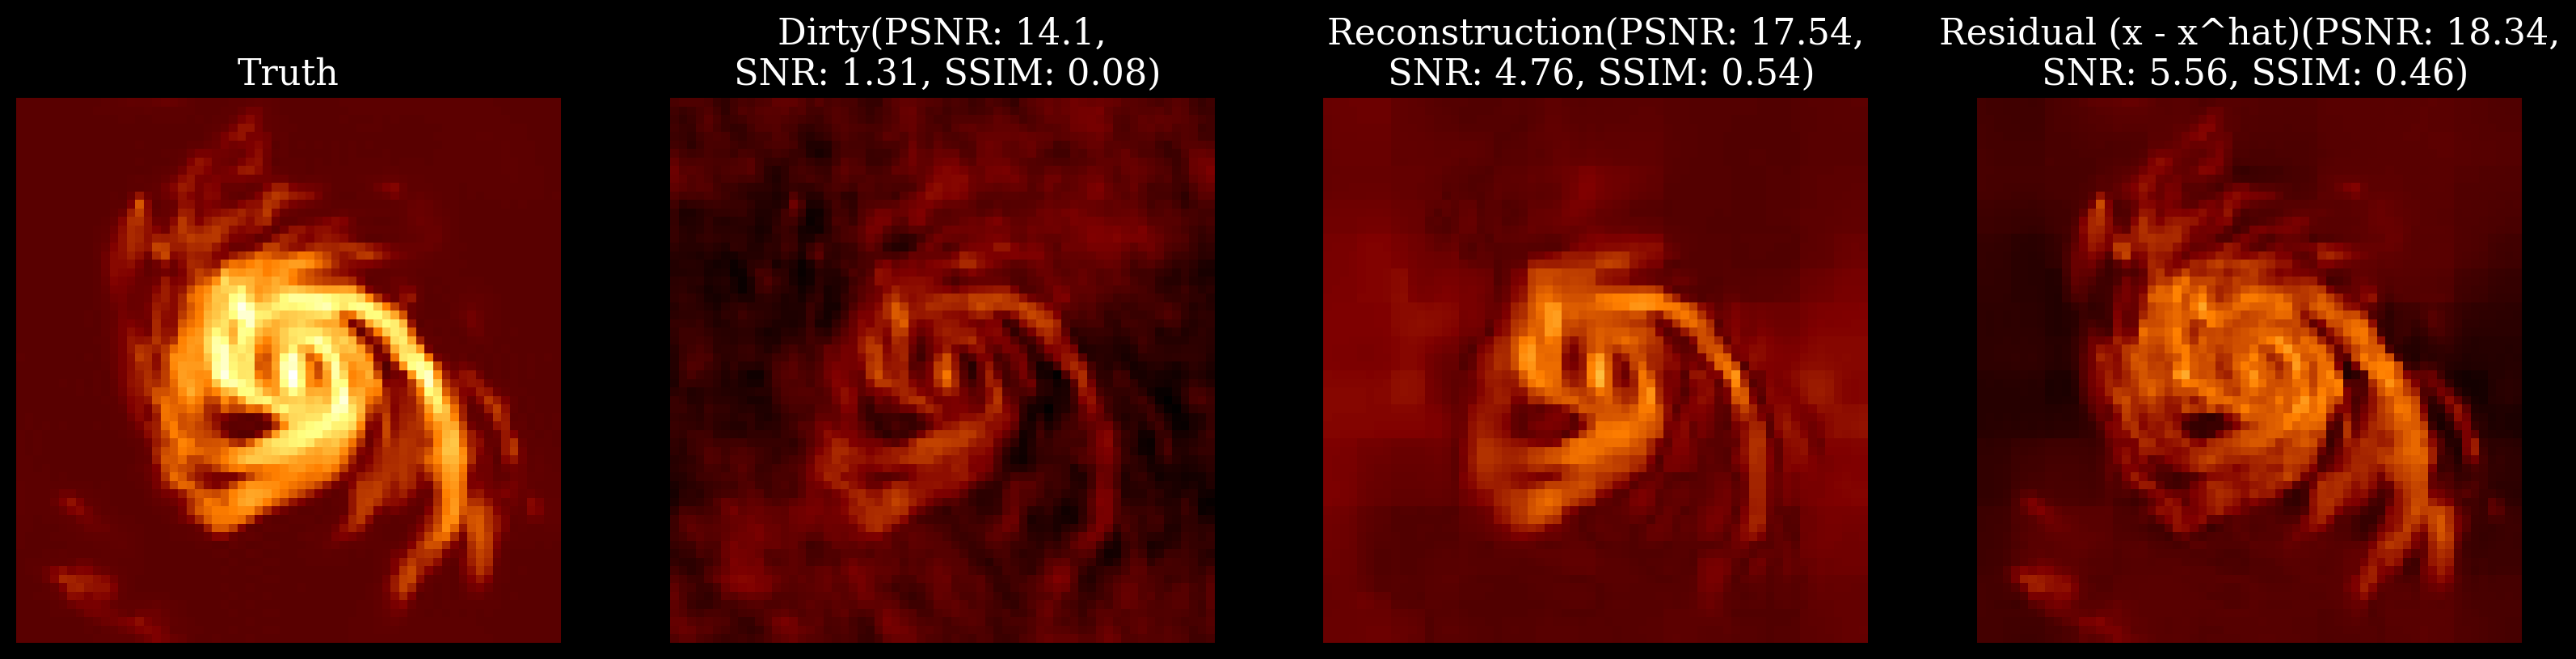

In [79]:
images = [x, x_init, np.abs(wvlt_FB_best_estimate), x-np.abs(wvlt_FB_best_estimate)]
labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]

fig, axs = plt.subplots(1,4, figsize=(20,8), dpi=200)
for i in range(4):
    axs[i].imshow(images[i], cmap='afmhot', vmax=np.nanmax(images), vmin=np.nanmin(images))
    if i > 0:   
        stats_str = '(PSNR: {},\n SNR: {}, SSIM: {})'.format(
            round(psnr(ground_truth, images[i]), 2),
            round(eval_snr(x, images[i]), 2),
            round(ssim(ground_truth, images[i]), 2),
            )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')

plt.show()

## CRR-based solution

In [48]:
options = {"tol": 1e-5, "iter": 2500, "update_iter": 50, "record_iters": False}

In [49]:
import torch
from convex_reg import utils
from tqdm import tqdm

gpu = False

if gpu:
    device = 'cuda:0'
    torch.set_grad_enabled(False)
    torch.set_num_threads(4)
else:
    device = 'cpu'
    

In [50]:
sigma_training = 25
t = 5
dir_name = '/Users/tliaudat/Documents/postdoc/github/convex_ridge_regularizers/trained_models/'
exp_name = f'Sigma_{sigma_training}_t_{t}/'
model = utils.load_model(dir_name+exp_name, device, gpu=gpu)

print(f'Numbers of parameters before prunning: {model.num_params}')
model.prune()
print(f'Numbers of parameters after prunning: {model.num_params}')


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183


In [51]:

myType = torch.float32

y_torch = torch.tensor(y, device=device, dtype=myType, requires_grad=False).reshape((1,1) + y.shape) # .to(torch.float32)
x_torch = torch.tensor(x, device=device, dtype=myType, requires_grad=False).reshape((1,1) + x.shape) # .to(torch.float32)


In [52]:
# Define the grad
g = optpr.grad_operators.l2_norm(sigma, y, phi)
g.beta = 1.0 / sigma ** 2

# Real prox 
f = optpr.prox_operators.real_prox()
# f = None


In [61]:
# Gradient descent

# phi.adj_op()
# phi.dir_op()

x_init = np.real(phi.adj_op(y))
x_init_torch = torch.tensor(x_init, device=device, dtype=myType, requires_grad=False).reshape((1,1) + x_init.shape) 

# optimization settings
tol = 1e-4
n_iter_max = 1500
lmbd = 3 # 4.5 # 6
mu = 20

# stepsize rule
L = model.L
alpha = 1. / ( 1. + g.beta + mu * lmbd * L)

# initialization
x_hat = torch.clone(x_init_torch)
z = torch.clone(x_init_torch)
t = 1


In [62]:
print(g.grad(z.squeeze()).shape)
print(x_hat.shape)
print((lmbd * model(mu * z)).shape)
print(torch.tensor(g.grad(z.squeeze()), device=device).reshape((1,1) + x_init.shape).shape)

(64, 64)
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])


In [63]:


for i in tqdm(range(options['iter'])):
    x_hat_old = torch.clone(x_hat)
    # grad = g.grad(z.squeeze()) +  lmbd * model(mu * z)
    x_hat = z - alpha *(torch.tensor(g.grad(z.detach().cpu().squeeze()), device=device, dtype=myType).reshape((1,1) + x_init.shape) + lmbd * model(mu * z))
    x_hat =  torch.real(x_hat)
    # possible constraint, AGD becomes FISTA
    # e.g. if positivity
    # x = torch.clamp(x, 0, None)
    
    t_old = t 
    t = 0.5 * (1 + np.sqrt(1 + 4*t**2))
    z = x_hat + (t_old - 1)/t * (x_hat - x_hat_old)

    # relative change of norm for terminating
    res = (torch.norm(x_hat_old - x_hat)/torch.norm(x_hat_old)).item()
    if res < tol:
        break



 73%|███████▎  | 1834/2500 [00:08<00:03, 206.33it/s]


<ipython-input-64-800de2bf9de1>:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr(ground_truth, images[i]),


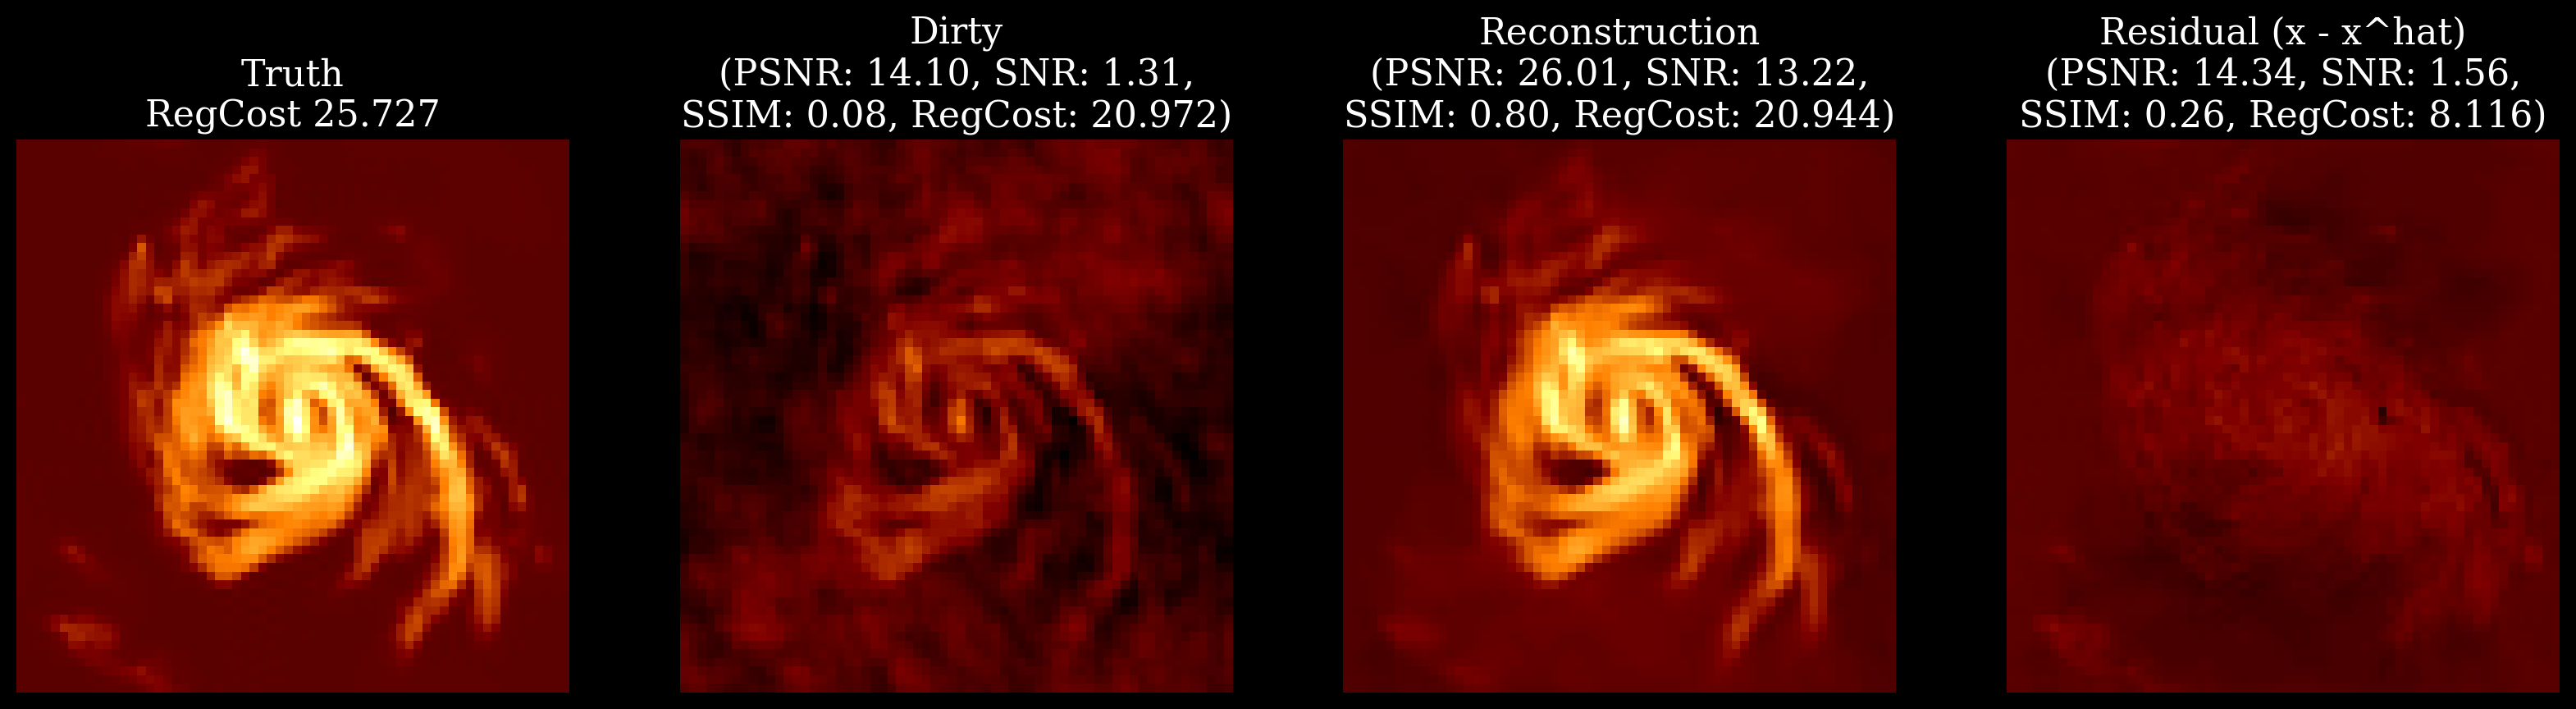

In [64]:
x_hat_np = x_hat.detach().cpu().squeeze().numpy()

images = [x, x_init, x_hat_np, x-np.abs(x_hat_np)]
images_torch = [x_torch, x_init_torch, x_hat, x_torch-x_hat]
labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]

fig, axs = plt.subplots(1,4, figsize=(20,8), dpi=200)
for i in range(4):
    im = axs[i].imshow(images[i], cmap='afmhot', vmax=np.nanmax(images), vmin=np.nanmin(images))
    if i == 0:
        stats_str = '\nRegCost {:.3f}'.format(model.cost(mu * images_torch[i])[0].item())
    if i > 0:   
        stats_str = '\n(PSNR: {:.2f}, SNR: {:.2f},\nSSIM: {:.2f}, RegCost: {:.3f})'.format(
            psnr(ground_truth, images[i]),
            eval_snr(x, images[i]),
            ssim(ground_truth, images[i]),
            model.cost(mu * images_torch[i])[0].item(),
            )
    labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')
plt.show()

## Naive gradient descent


In [65]:
# optimization settings
tol = 1e-4

x_init = np.real(phi.adj_op(y))

# stepsize rule
alpha = 1. / ( 1. + g.beta)

# initialization
x_hat_naive = np.copy(x_init)
z_naive = np.copy(x_init)
t_naive = 1

In [68]:
for i in tqdm(range(options['iter'])):
    x_hat_old_naive = np.copy(x_hat_naive)
    # grad = g.grad(z.squeeze()) 
    x_hat_naive = z_naive - alpha * g.grad(z_naive) 
    x_hat_naive =  np.real(x_hat_naive)
    # possible constraint, AGD becomes FISTA
    # e.g. if positivity
    # x = torch.clamp(x, 0, None)
    
    t_old_naive = t_naive 
    t_naive = 0.5 * (1 + np.sqrt(1 + 4*t_naive**2))
    z_naive = x_hat_naive + (t_old_naive - 1)/t_naive * (x_hat_naive - x_hat_old_naive)

    # relative change of norm for terminating
    res = (np.linalg.norm(x_hat_old_naive - x_hat_naive)/np.linalg.norm(x_hat_old_naive))
    if res < tol:
        break


  1%|          | 14/2500 [00:00<00:02, 840.29it/s]


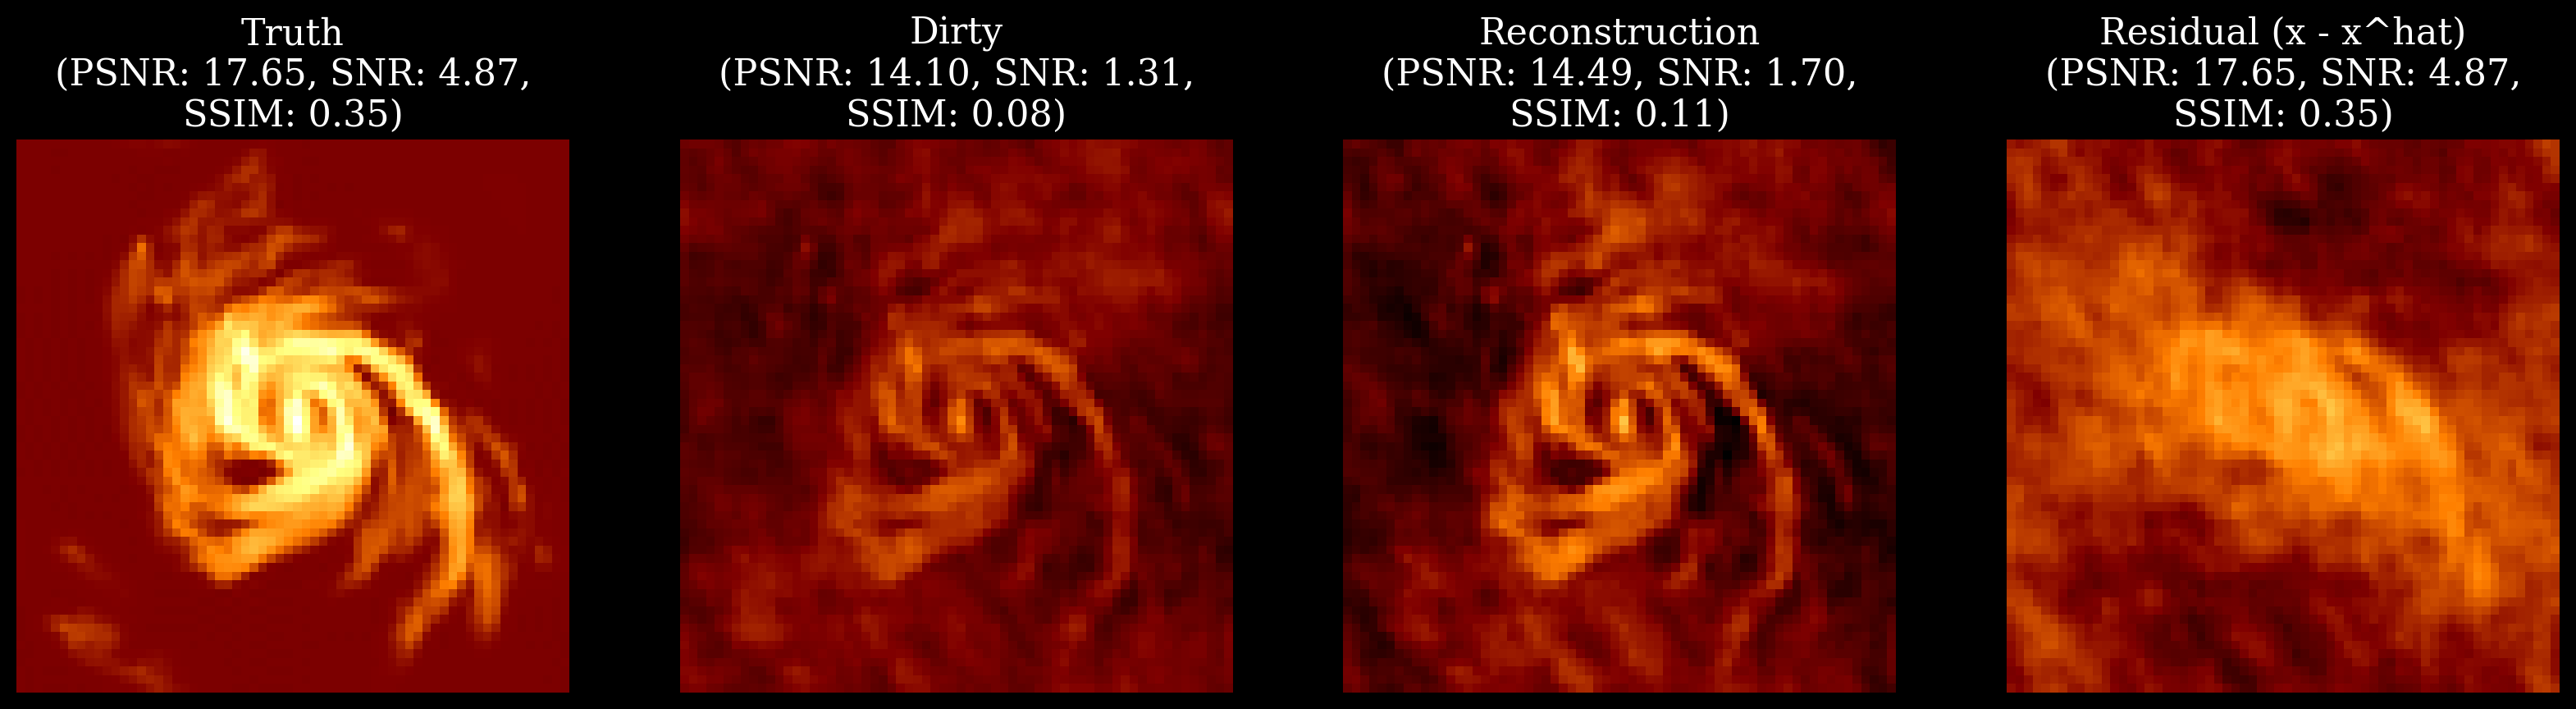

In [70]:


images = [x, x_init, x_hat_naive, x - (x_hat_naive)]
labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]

fig, axs = plt.subplots(1,4, figsize=(20,8), dpi=200)
for i in range(4):
    im = axs[i].imshow(images[i], cmap='afmhot', vmax=np.nanmax(images), vmin=np.nanmin(images))
    if i > 0:   
        stats_str = '\n(PSNR: {:.2f}, SNR: {:.2f},\nSSIM: {:.2f})'.format(
            psnr(ground_truth, images[i]),
            eval_snr(x, images[i]),
            ssim(ground_truth, images[i])
            )
    labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')
plt.show()



In [82]:
x.min()

0.0

In [23]:
class CRR_prox(optpr.prox_operators.ProximalOperator):
    """This class computes the proximity operator of CRR regularisation.

    """

    def __init__(self, model, mu=1, lmbd=1):
        """
        Initialises a positive half-plane proximal operator class
        """
        self.mu = mu
        self.lmbd = lmbd
        self.model = model

        self.beta =  self.mu * self.lmbd * self.model.L

    def prox(self, x, tau):
        """Denoises the image with the CRR denoising convex reg.

        Args:

            x (np.ndarray): Array to evaluate proximal operator

        Returns:

            gradient step denoising
        """
        x_torch = torch.tensor(x, device=device, dtype=torch.float32).reshape((1,1) + x.shape)

        return self.lmbd * self.model(self.mu * x_torch).detach().squeeze().numpy()

    def fun(self, x, tau):
        """Evaluates loss of functional term

        Args:

            x (np.ndarray): Array to evaluate loss of

        Returns:

            0
        """
        x_torch = torch.tensor(x, device=device, dtype=torch.float32).reshape((1,1) + x.shape)

        return self.lmbd * self.model.cost(self.mu * x_torch).detach().squeeze().numpy()

    def dir_op(self, x):
        """Evaluates the forward operator

        Args:

            x (np.ndarray): Array to forward transform

        Returns:

            Forward operator applied to x
        """
        return x

    def adj_op(self, x):
        """Evaluates the forward adjoint operator

        Args:

            x (np.ndarray): Array to forward adjoint transform

        Returns:

            Forward adjoint operator applied to x
        """
        return x

In [24]:
# Define the prox denoising for the CRR
mu = 1
lmbd = 0.1
# lmbd * model(mu * z)

h = CRR_prox(model, mu, lmbd)



In [25]:
# Run the alg
L = model.L.numpy()
alpha = 2. / (g.beta * mu * lmbd * L + 2.)
print(alpha)

CRR_best_estimate, CRR_diagnostics = optpr.forward_backward.FB(
    x_init=x_init, options=options, g=g, f=f, h=h, alpha=alpha, tau=1
)

CRR_best_estimate = np.abs(CRR_best_estimate)


0.7847741676848359
2023-02-01 13:22:40,635 - Optimus Primal - INFO - Running Base Forward Backward
2023-02-01 13:22:40,650 - Optimus Primal - INFO - [Forward Backward] 0 out of 2500 iterations, tol = 0.996924
2023-02-01 13:22:40,798 - Optimus Primal - INFO - [Forward Backward] converged in 11 iterations


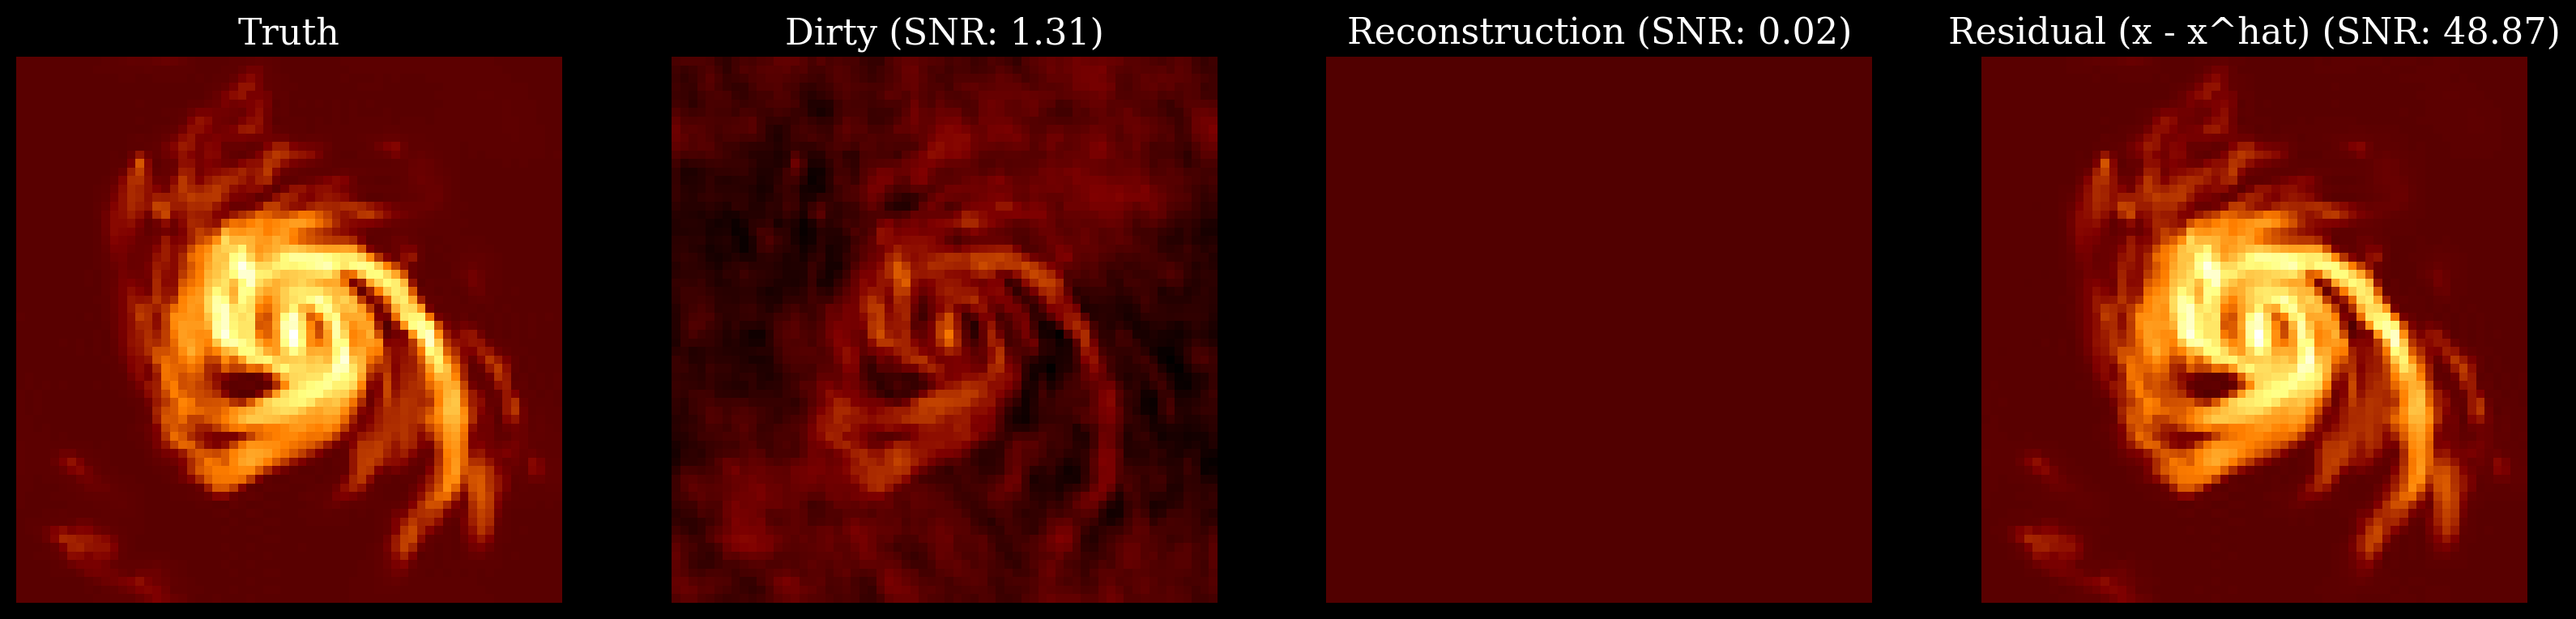

In [26]:
def eval_snr(x, x_est):
    if np.array_equal(x, x_est):
        return 0
    num = np.sqrt(np.sum(np.abs(x) ** 2))
    den = np.sqrt(np.sum(np.abs(x - x_est) ** 2))
    return round(20*np.log10(num/den), 2)

plt.style.use('dark_background')
plt.rcParams["font.family"] = "serif"

images = [x, x_init, np.abs(CRR_best_estimate), x-np.abs(CRR_best_estimate)]
labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]

fig, axs = plt.subplots(1,4, figsize=(20,8), dpi=200)
for i in range(4):
    axs[i].imshow(images[i], cmap='afmhot', vmax=np.nanmax(images), vmin=np.nanmin(images))
    if i > 0:   
        # stats_str = ' (PSNR: {}, SSIM: {})'.format(
        #     round(psnr(ground_truth, images[i]), 2),
        #     round(ssim(ground_truth, images[i]), 2)
        #     )
        stats_str = ' (SNR: {})'.format(
            round(eval_snr(x, images[i]), 2)
            )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')

plt.show()
